In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import ghibtools as gh
from params import patients

- **We saw that frontal chans are the best to see spindles, so here we are going to sel just one channel : the mean between Fp2-C4 and Fp1-C3**
- **Going to make a dim "normalisation" with coords ('raw','normalized') to get normalisation by participant**
- **At the end, one xarray for all patients, multi-indexed on cycle label to get the idea of spindling in cycles**
- **Then going to convert data to float 32 for faster computing and less memory**

In [3]:
def all_in_one(patient , save=False):
    da = xr.load_dataarray(f'../dataarray/da_tf_stretched_{patient}.nc') 
    da_frontal = da.sel(chan = ['Fp2-C4','Fp1-C3']).mean('chan') # mean frontal chans
    del da
    
    cycles_spindled = list(np.load(f'../df_analyse/cycles_spindled_{patient}.npy'))
    all_cycles = list(da_frontal.coords['cycle'].values)
    cycles_without_spindle = [c for c in all_cycles if not c in cycles_spindled]
    
    df = pd.DataFrame(index = all_cycles, columns = ['spindling code','spindling label'])
    
    for c in all_cycles:
        if c in cycles_spindled:
            df.loc[c, 'spindling code'] = 1
            df.loc[c, 'spindling label'] = 'spindled'
        elif c in cycles_without_spindle:
            df.loc[c, 'spindling code'] = 0
            df.loc[c, 'spindling label'] = 'unspindled'
            
    if save:
        df.to_excel(f'../df_analyse/cycle_encoding_{patient}.xlsx')
    
    da_tf_frontal_midx = gh.midx_da(da = da_frontal , dim = 'cycle', midx_labels = ('c','spindling'), midx_coords = [all_cycles, list(df.loc[:,'spindling label'])]) # midx
    da_tf_frontal_midx_norm = gh.norm(da_tf_frontal_midx) # normalize
    da_both = xr.concat([da_tf_frontal_midx , da_tf_frontal_midx_norm], dim = 'normal') # keep norm and not normed
    da_both = da_both.assign_coords({'normal':['raw','norm']})
    da_both_retype = da_both.astype('float32') # to float 32
    
    if save:
        da_both_retype.reset_index('cycle').to_netcdf(f'../dataarray/da_frontal_midx_{patient}.nc')
        
    da_gby_spindling = da_both_retype.sel(normal = 'norm').groupby('spindling').mean()
    
    da_mean_diff = da_gby_spindling.sel(spindling = 'spindled') - da_gby_spindling.sel(spindling = 'unspindled')
    da_all_mean = da_both_retype.mean('cycle').sel(normal = 'norm')
    da_spindled = da_gby_spindling.sel(spindling = 'spindled')
    da_unspindled =  da_gby_spindling.sel(spindling = 'unspindled')
    
    da_concat_means = xr.concat([da_all_mean, da_spindled, da_unspindled, da_mean_diff], dim = 'cycle_type', coords = 'minimal', compat = 'override')
    da_concat_means = da_concat_means.assign_coords({'cycle_type':['all','spindled', 'unspindled', 'diff']})
    
    return da_concat_means

In [4]:
save = True

In [5]:
concat = []
for patient in patients:
    concat.append(all_in_one(patient, save = save))
da_all_means = xr.concat(concat, dim = 'patient')
da_all_means = da_all_means.assign_coords({'patient':patients})

if save:
    da_all_means.to_netcdf('../dataarray/da_tf_all_means.nc')

In [6]:
da_all_means

<xarray.DataArray (patient: 10, cycle_type: 4, freqs: 40, point: 1000)>
array([[[[ 2.35166535e-01,  2.34876066e-01,  2.34589532e-01, ...,
           2.36077249e-01,  2.35785797e-01,  2.35477373e-01],
         [ 1.92123264e-01,  1.91738695e-01,  1.91360131e-01, ...,
           1.93225309e-01,  1.92865238e-01,  1.92485735e-01],
         [ 1.58142850e-01,  1.57729164e-01,  1.57323539e-01, ...,
           1.59238189e-01,  1.58881143e-01,  1.58500910e-01],
         ...,
         [-3.07135910e-01, -3.07150126e-01, -3.07164788e-01, ...,
          -3.07052910e-01, -3.07085633e-01, -3.07114780e-01],
         [-3.08421314e-01, -3.08433294e-01, -3.08445185e-01, ...,
          -3.08348507e-01, -3.08372587e-01, -3.08395773e-01],
         [-3.09691072e-01, -3.09695959e-01, -3.09700608e-01, ...,
          -3.09642613e-01, -3.09652686e-01, -3.09663802e-01]],

        [[ 1.93783402e-01,  1.92515269e-01,  1.91265002e-01, ...,
           2.30615497e-01,  2.30439782e-01,  2.30258957e-01],
         [ 1.47835553e-01,  1.46511003e-01,  1.45213023e-01, ...,
           1.97565481e-01,  1.97180927e-01,  1.96784765e-01],
         [ 1.10942550e-01,  1.09655641e-01,  1.08401947e-01, ...,
           1.69209987e-01,  1.68639973e-01,  1.68051571e-01],
...
          -2.90376514e-01, -2.90649295e-01, -2.90860653e-01],
         [-2.94219613e-01, -2.94533998e-01, -2.94865310e-01, ...,
          -2.96440929e-01, -2.96801776e-01, -2.97086358e-01],
         [-3.02650839e-01, -3.02997530e-01, -3.03363264e-01, ...,
          -3.03585082e-01, -3.04022700e-01, -3.04375976e-01]],

        [[-1.23033471e-01, -1.21816829e-01, -1.20646372e-01, ...,
           5.56758642e-02,  5.75127751e-02,  5.54303676e-02],
         [-1.10981584e-01, -1.09753206e-01, -1.08577177e-01, ...,
           8.41898620e-02,  8.59784111e-02,  8.45147520e-02],
         [-9.55903679e-02, -9.42648277e-02, -9.29926783e-02, ...,
           1.09256737e-01,  1.11188762e-01,  1.09971665e-01],
         ...,
         [-6.11553788e-02, -6.08745217e-02, -6.05764091e-02, ...,
          -5.44599891e-02, -5.38231730e-02, -5.39788902e-02],
         [-5.57294190e-02, -5.54260612e-02, -5.51036000e-02, ...,
          -5.10738492e-02, -5.02551496e-02, -5.04268110e-02],
         [-4.86529171e-02, -4.83251214e-02, -4.79777753e-02, ...,
          -4.66699302e-02, -4.57220972e-02, -4.58898246e-02]]]],
      dtype=float32)
Coordinates:
    spindling   <U8 'spindled'
  * freqs       (freqs) float64 10.0 10.26 10.51 10.77 ... 19.49 19.74 20.0
  * point       (point) int64 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
    normal      <U4 'norm'
  * cycle_type  (cycle_type) <U10 'all' 'spindled' 'unspindled' 'diff'
  * patient     (patient) <U3 'P1' 'P2' 'P3' 'P4' 'P5' 'P6' 'P7' 'P8' 'P9' 'P10'

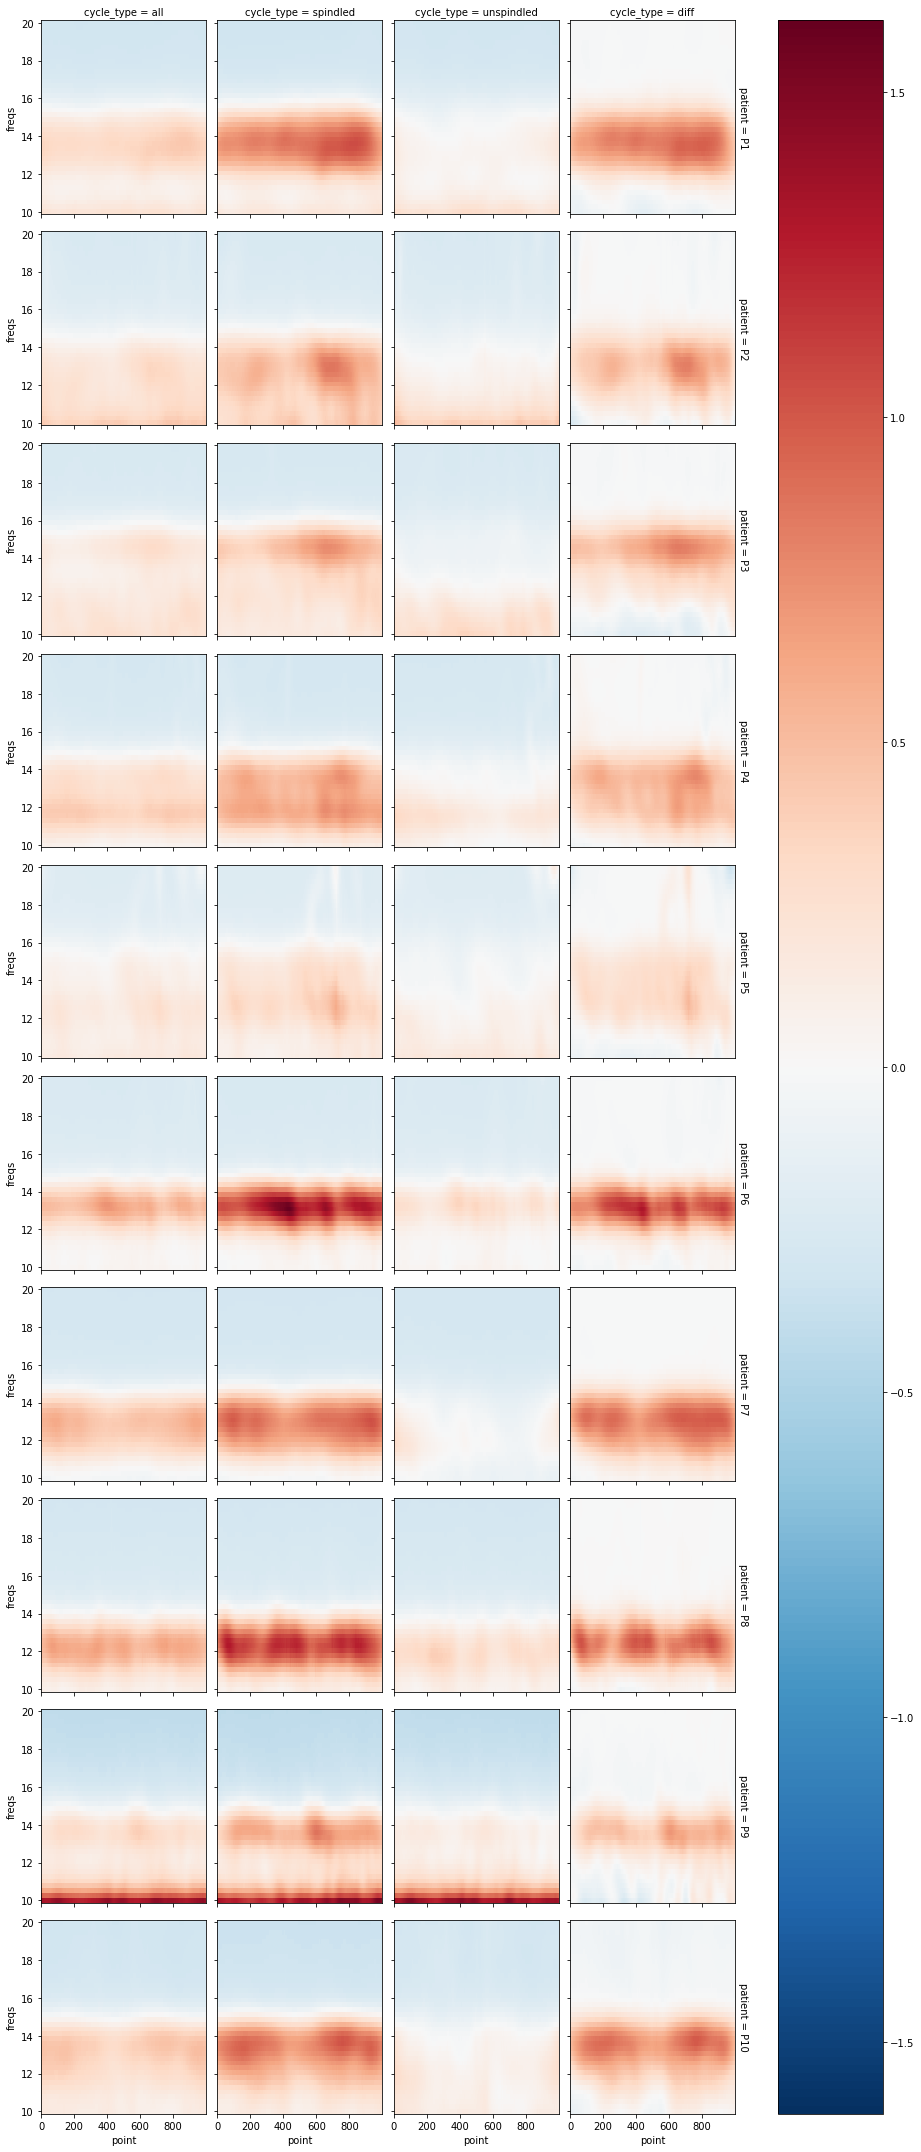

In [8]:
da_all_means.plot.pcolormesh(x='point',row = 'patient', col = 'cycle_type')

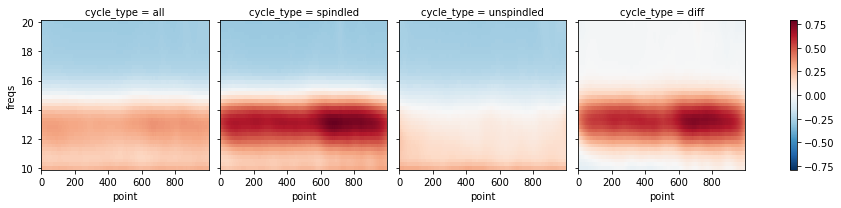

In [9]:
da_all_means.mean('patient').plot.pcolormesh(x='point', col = 'cycle_type')

In [4]:
def to_tf_frontal(patient , save=False):
    da = xr.load_dataarray(f'../dataarray/da_tf_{patient}.nc') 
    da_frontal = da.sel(chan = ['Fp2-C4','Fp1-C3']).mean('chan').astype('float32') # mean frontal chans and float 32
    del da
    concat = [da_frontal , gh.norm(da_frontal)]
    da_save = xr.concat(concat, dim = 'normalisation')
    da_save = da_save.assign_coords({'normalisation':['raw','normal']})
    del da_frontal
    if save:
        da_save.to_netcdf(f'../dataarray/da_tf_frontal_{patient}.nc')
    del da_save

In [5]:
save = False
for patient in patients:
    print(patient)
    to_tf_frontal(patient, save=save)

P1
P2
P3
P4
P5
P6
P7
P8
P9
P10


In [3]:
def code_rsp_features_with_spindling(patient, save=False):
    rsp_patient = pd.read_excel(f'../df_analyse/resp_features_new_{patient}.xlsx', index_col = 0)
    encoding = pd.read_excel(f'../df_analyse/cycle_encoding_{patient}.xlsx').rename(columns = {'Unnamed: 0':'cycle'})
    rsp_return = pd.concat([rsp_patient, encoding['spindling code']], axis = 1)
    if save:
        rsp_return.iloc[:,1:].drop(columns = 'cycle_num').to_excel(f'../df_analyse/resp_features_encoded_{patient}.xlsx')

In [4]:
for patient in patients:
    code_rsp_features_with_spindling(patient, save=True)

In [3]:
da = xr.load_dataarray('../dataarray/da_frontal_midx_P1.nc')

In [4]:
da

<xarray.DataArray (normal: 2, cycle: 2348, freqs: 40, point: 1000)>
array([[[[ 1.59626074e+03,  1.61613855e+03,  1.63601636e+03, ...,
           4.62301758e+02,  4.75351898e+02,  4.88412506e+02],
         [ 1.49724341e+03,  1.52852588e+03,  1.55980835e+03, ...,
           5.11124268e+02,  5.31319336e+02,  5.51540283e+02],
         [ 1.27696216e+03,  1.31876965e+03,  1.36057727e+03, ...,
           6.50404297e+02,  6.71918823e+02,  6.93471619e+02],
         ...,
         [ 8.10412415e+02,  8.19023987e+02,  8.27635620e+02, ...,
           3.91753387e+02,  4.10332977e+02,  4.28932678e+02],
         [ 7.50981079e+02,  7.58517578e+02,  7.66054016e+02, ...,
           4.31494568e+02,  4.52193878e+02,  4.72918304e+02],
         [ 6.19361694e+02,  6.27605652e+02,  6.35849670e+02, ...,
           5.45804871e+02,  5.65782227e+02,  5.85782227e+02]],

        [[ 4.98944824e+02,  5.09430756e+02,  5.19160095e+02, ...,
           2.60676587e+03,  2.68427930e+03,  2.76366675e+03],
         [ 5.67819458e+02,  5.84026428e+02,  5.98978943e+02, ...,
           2.05247559e+03,  2.11988306e+03,  2.18977002e+03],
         [ 7.10897827e+02,  7.28248352e+02,  7.44250366e+02, ...,
           1.56499341e+03,  1.62715137e+03,  1.69245483e+03],
...
          -2.70990074e-01, -2.72931099e-01, -2.74879277e-01],
         [-3.57207388e-01, -3.57079685e-01, -3.56950462e-01, ...,
          -2.75698215e-01, -2.77997673e-01, -2.80300111e-01],
         [-3.61103207e-01, -3.61030012e-01, -3.60951394e-01, ...,
          -2.77316868e-01, -2.79854387e-01, -2.82393008e-01]],

        [[ 1.33137774e+00,  1.31959927e+00,  1.30782080e+00, ...,
          -3.00691515e-01, -3.00461709e-01, -3.00231874e-01],
         [ 1.14385259e+00,  1.13521874e+00,  1.12658489e+00, ...,
          -3.20552558e-01, -3.20060998e-01, -3.19569439e-01],
         [ 9.45098937e-01,  9.38970923e-01,  9.32842910e-01, ...,
          -3.27987224e-01, -3.27558309e-01, -3.27129364e-01],
         ...,
         [-2.76827455e-01, -2.78574735e-01, -2.80322015e-01, ...,
          -3.05421919e-01, -3.04944277e-01, -3.04466635e-01],
         [-2.82602549e-01, -2.84646541e-01, -2.86690563e-01, ...,
          -2.92406172e-01, -2.92240292e-01, -2.92074412e-01],
         [-2.84931660e-01, -2.87178040e-01, -2.89424449e-01, ...,
          -2.81437248e-01, -2.81542093e-01, -2.81646937e-01]]]],
      dtype=float32)
Coordinates:
  * freqs      (freqs) float64 10.0 10.26 10.51 10.77 ... 19.23 19.49 19.74 20.0
  * point      (point) int64 0 1 2 3 4 5 6 7 ... 992 993 994 995 996 997 998 999
  * normal     (normal) object 'raw' 'norm'
    c          (cycle) int64 0 1 2 3 4 5 6 ... 2342 2343 2344 2345 2346 2347
    spindling  (cycle) object 'unspindled' 'unspindled' ... 'unspindled'
Dimensions without coordinates: cycle